<a href="https://colab.research.google.com/github/Iwillnottellyou/l0l1-SVGD/blob/main/stein_importance_SVGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0.008650457867970082 0.28
0.0046972587855511885 0.23
0.0020656269875909874 0.23
0.0021032558675371793 0.2
0.0011932540424712253 0.17
0.0011932082912827593 0.16
0.0017781520144934623 0.17
0.0011561476356763867 0.16
0.0009297364776521663 0.16
0.0008590215233932513 0.16
0.0007408154085977655 0.15
0.0006568183699614651 0.15
0.0006371550153258413 0.15
0.0005246038456795906 0.15
0.000567766322406362 0.15
0.0004474995534027586 0.14
0.0005382286460696978 0.14
0.00041750821975992605 0.14
0.0005460501950966505 0.14
0.00042199293600470456 0.14
0.0005676364111447016 0.14
0.0004172650068851791 0.14
0.0005808571953467288 0.14
0.00044124640595614707 0.14
0.0005647919458881157 0.12
0.00043230245660595224 0.12
0.0005626259539417087 0.12
0.0004222939963063887 0.12
0.0005306464416755095 0.11
0.00039839011604673037 0.11
0.0005021772480111337 0.11
0.0003818059390359176 0.11
0.0004565734680984456 0.11
0.00036517052637448583 0.11
0.00041523795025382647 0.11
0.0003442005540221358 0.11
0.0003727114389494125 0.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


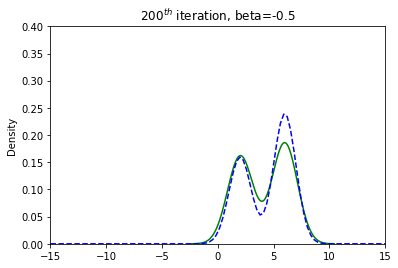

In [305]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

def mirror_descent(A,iter,stepsize,omega,alpha):
    iter= iter
    stepsize=stepsize
    n = omega.shape[0]
    for j in range(iter):
        omega_m = np.matmul(A,omega)
        for i in range(n):
          omega[i]=omega[i]*np.exp(-stepsize*omega_m[i])
        omega = (1/omega.sum())*omega 

    return omega 

def mirror_descent_heavy_ball(A,iter,stepsize,omega,alpha):
    iter= iter
    stepsize=stepsize
    omega_m = omega
    omegaold = omega
    n = omega.shape[0]
    for j in range(iter):
        omega_m = omegaold
        omegaold = omega
        for i in range(n):
          omega[i]=omega[i]*np.exp(-stepsize*np.matmul(A[i],omegaold)+alpha*(omegaold[i]-omega_m[i]))
        omega = (1/omega.sum())*omega 
    #print(omega)

    return omega 

def mirror_descent_momentum(A,iter,stepsize,omega,alpha):
    iter= iter
    stepsize=stepsize
    omega_m = omega
    n = omega.shape[0]
    for j in range(iter):
        omega_m = alpha*omega_m + np.matmul(A,omega)
        for i in range(n):
          omega[i]=omega[i]*np.exp(-stepsize*omega_m[i])
        omega = (1/omega.sum())*omega 
    print(np.matmul(np.matmul(A,omega),omega),sum(i>0.3 for i in n*omega)/n)

    return omega 

class SVGD_model():

    def __init__(self):
        pass


    def SVGD_kernal(self, x,beta, h=-1):
        init_dist = pdist(x)
        pairwise_dists = squareform(init_dist)
        if h < 0:  # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = h ** 2 / np.log(x.shape[0] + 1)

        kernal_xj_xi = np.exp(- pairwise_dists ** 2 / h)/ (np.sqrt( np.pi * h))

        d_kernal_xi = np.zeros(x.shape)
        for i_index in range(x.shape[0]):
            d_kernal_xi[i_index] = np.matmul(kernal_xj_xi[i_index], x[i_index] - x) * 2 / (np.sqrt( np.pi * h)*h)

        if beta == 0:
          return kernal_xj_xi, d_kernal_xi

        else:
          d_kernal_xj_xi=np.zeros([x.shape[0],x.shape[0]])
          for i_index in range(x.shape[0]):
            for j_index in range(x.shape[0]):
              d_kernal_xj_xi[i_index][j_index]=(2/h)*(x[j_index]-x[i_index])
          d_kernal_xj_xi = np.multiply(kernal_xj_xi,d_kernal_xj_xi)
        
          dd_kernal_xj_xi=np.zeros([x.shape[0],x.shape[0]])
          dd_kernal_xj_xi= np.multiply(kernal_xj_xi,2/h-4*pairwise_dists**2/h**2)

        return kernal_xj_xi, d_kernal_xi,dd_kernal_xj_xi,d_kernal_xj_xi

    def update(self, x0, lnprob,probdensity,beta, n_iter=1000, stepsize=1e-3,opt_step = 1,opt_iter=20, bandwidth=-1, debug=False,alpha=0.5,optimization_choice=1):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')

        x = np.copy(x0)
        n = x.shape[0]
        omega = 1/n*np.ones(n)
        # adagrad with momentum
        eps_factor = 1e-8
        historical_grad_square = 0
        for iter in range(n_iter):
            if debug and (iter + 1) % 1000 == 0:
                print('iter ' + str(iter + 1))
            gradmatrix = lnprob(x)

            if beta==0:
              kernal_xj_xi, d_kernal_xi = self.SVGD_kernal(x,0, bandwidth)
              current_grad = (np.matmul(kernal_xj_xi, gradmatrix) + d_kernal_xi) / n
              x += stepsize * current_grad
            else:
              kernal_xj_xi, d_kernal_xi,dd_kernal_xj_xi,d_kernal_xj_xi = self.SVGD_kernal(x,beta, bandwidth)

              SteinMatrix = np.multiply(kernal_xj_xi,np.matmul(gradmatrix,gradmatrix.transpose()))
              +dd_kernal_xj_xi+np.matmul(np.diag(gradmatrix.transpose()[0]),d_kernal_xj_xi).transpose()+np.matmul(d_kernal_xj_xi.transpose(),np.diag(gradmatrix.transpose()[0])).transpose()

              if optimization_choice == 1:
                omega = mirror_descent(SteinMatrix,opt_iter,opt_step,omega,alpha) 
              if optimization_choice == 2:
                omega = mirror_descent_heavy_ball(SteinMatrix,opt_iter,opt_step,omega,alpha) 
              if optimization_choice == 3:
                omega = mirror_descent_momentum(SteinMatrix,opt_iter,opt_step,omega,alpha) 

              current_grad = np.multiply(np.mat((n*omega+0.01)**(beta)).transpose(),(np.matmul(kernal_xj_xi, gradmatrix) + d_kernal_xi)) / n
              x += stepsize * current_grad
        return x



sns.set_palette('deep', desat=.6)
sns.set_context(rc={'figure.figsize': (8, 5) } )

class OneDimensionGM():

    def __init__(self, omega, mean, var):
        self.omega = omega
        self.mean = mean
        self.var = var

    def dlnprob(self, x):
        rep_x = np.matlib.repmat(x, 1, self.omega.shape[0])
        category_prob = np.exp(- (rep_x - self.mean) ** 2 / (2 * self.var)) / (np.sqrt(2 * np.pi * self.var)) * self.omega
        den = np.sum(category_prob, 1)
        num = ((- (rep_x - self.mean) / self.var) * category_prob).sum(1)
        return np.expand_dims((num / den), 1)

    def MGprob(self, x):
        rep_x = np.matlib.repmat(x, 1, self.omega.shape[0])
        category_prob = np.exp(- (rep_x - self.mean) ** 2 / (2 * self.var)) / (np.sqrt(2 * np.pi * self.var)) * self.omega
        den = np.sum(category_prob, 1)
        return np.expand_dims(den, 1)

if __name__ == "__main__":

    w = np.array([0.4,0.6])
    mean = np.array([2,6])
    var = np.array([1,1])

    OneDimensionGM_model = OneDimensionGM(w, mean, var)

    np.random.seed(0)
    num_particle = 100
    x0 = np.random.normal(0, 2, [num_particle, 1]);
    dlnprob = OneDimensionGM_model.dlnprob
    probdensity=OneDimensionGM_model.MGprob

    svgd_model = SVGD_model()
    n_iter = 200
    beta =-0.5
   
    x = svgd_model.update(x0, dlnprob, probdensity, beta, n_iter=n_iter, stepsize=0.5,opt_step=2, opt_iter=20, bandwidth=-1, debug=True,alpha=0.1,optimization_choice=3)


    #plot result
    sns.kdeplot(x.reshape((num_particle,)), bw = .4, color = 'g')

    mg_prob = OneDimensionGM_model.MGprob
    x_lin = np.expand_dims(np.linspace(-15, 15, 100), 1)
    x_prob = mg_prob(x_lin)
    plt.plot(x_lin, x_prob, 'b--')
    plt.axis([-15, 15, 0, 0.4])
    plt.title(str(n_iter) + '$ ^{th}$ iteration, '+'beta='+str(beta))
    plt.show()

#iter=20, out_stepsize=0.5, inner_stepsize=5,inner_iter=100

